In [1]:
import matplotlib.pyplot as plt
from pyteomics import mzml, mzmlb
import numpy as np
import pandas as pd

/home/wkumler/miniconda3/envs/mzMLb/lib/python3.12/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
mzml_file = mzml.MzML('210916_Poo_TruePooAmm-noIS-pos-Full_1.mzML')

## Create chromatogram extraction functions

              mz            int         rt
0     118.086647   60605.687500   0.078836
1     118.086632  416416.375000   0.088211
2     118.086678  534714.000000   0.097704
3     118.086403   12061.222656   0.107335
4     118.086792   20711.105469   0.107335
...          ...            ...        ...
2047  118.086540  587583.937500  21.945940
2048  118.086517  604980.687500  21.956561
2049  118.086502  666637.937500  21.967152
2050  118.086662    3315.736572  21.986608
2051  118.086670    3897.508545  22.006475

[2052 rows x 3 columns]


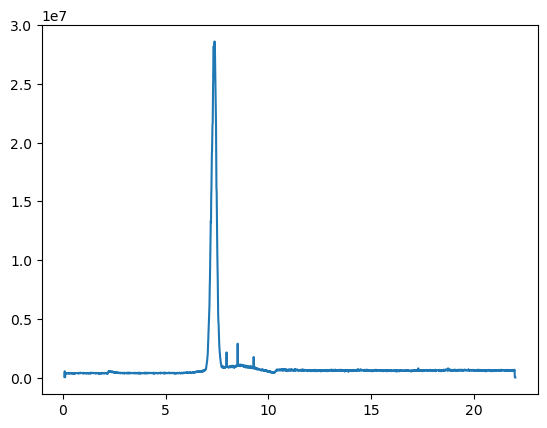

In [3]:
def get_chrom_mzml(file):
    scan_dfs = []
    for spectrum in mzml.MzML(file):
        if spectrum['ms level'] == 1:
            # print(spectrum["index"])
            mz_vals=spectrum['m/z array']
            int_vals = spectrum['intensity array']
            bet_mzs = mz_vals[abs(mz_vals-118.0865)<=0.001]
            bet_ints = int_vals[abs(mz_vals-118.0865)<=0.001]
            # print(bet_mzs)
            # print(bet_ints)
            rt_val = spectrum['scanList']['scan'][0]['scan start time']
            if(len(bet_mzs)>0):
                df_scan = pd.DataFrame({'mz':bet_mzs, 'int':bet_ints, 'rt':[rt_val]*len(bet_mzs)})
                scan_dfs.append(df_scan)    
    return(pd.concat(scan_dfs, ignore_index=True))
chrom_data = get_chrom_mzml('210916_Poo_TruePooAmm-noIS-pos-Full_1.mzML')
print(chrom_data)

plt.plot(chrom_data["rt"], chrom_data["int"])
plt.show()

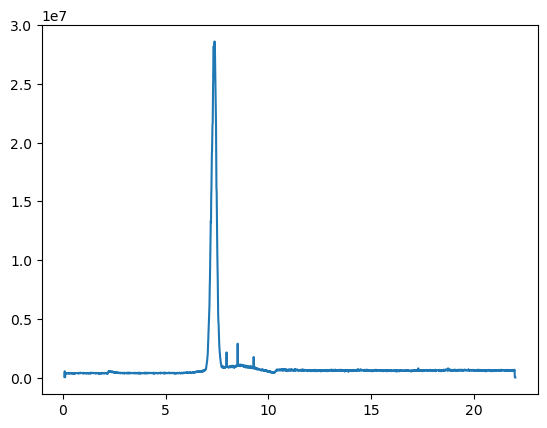

In [4]:
def get_chrom_mzmlb(file):
    scan_dfs = []
    for spectrum in mzmlb.MzMLb(file):
        if spectrum['ms level'] == 1:
            # print(spectrum["index"])
            mz_vals=spectrum['m/z array']
            int_vals = spectrum['intensity array']
            bet_mzs = mz_vals[abs(mz_vals-118.0865)<=0.001]
            bet_ints = int_vals[abs(mz_vals-118.0865)<=0.001]
            # print(bet_mzs)
            # print(bet_ints)
            rt_val = spectrum['scanList']['scan'][0]['scan start time']
            if(len(bet_mzs)>0):
                df_scan = pd.DataFrame({'mz':bet_mzs, 'int':bet_ints, 'rt':[rt_val]*len(bet_mzs)})
                scan_dfs.append(df_scan)    
    return(pd.concat(scan_dfs, ignore_index=True))
chrom_data = get_chrom_mzmlb('210916_Poo_TruePooAmm-noIS-pos-Full_1.mzMLb')

plt.plot(chrom_data["rt"], chrom_data["int"])
plt.show()

## Converting to database instead

In [5]:
import sqlite3
conn = sqlite3.connect("msdata.sqlite")
for spectrum in mzml.MzML('210916_Poo_TruePooAmm-noIS-pos-Full_1.mzML'):
    if spectrum['ms level'] == 1:
        # print(spectrum["index"])
        mz_vals=spectrum['m/z array']
        int_vals = spectrum['intensity array']
        rt_val = spectrum['scanList']['scan'][0]['scan start time']
        df_scan = pd.DataFrame({'mz':mz_vals, 'int':int_vals, 'rt':[rt_val]*len(mz_vals)})
        df_scan.to_sql("MS1", conn, if_exists="append", index=False)
conn.close()

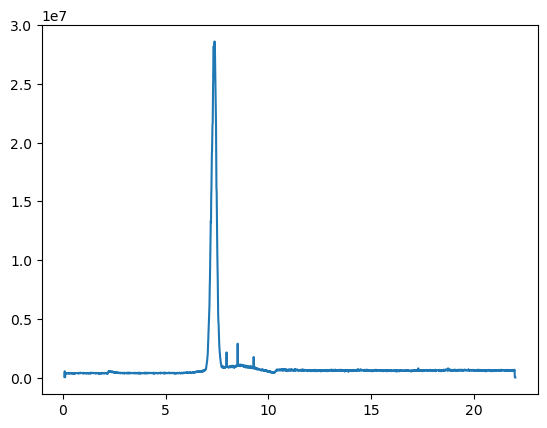

In [6]:
def get_chrom_sqlite3(database):
    conn = sqlite3.connect(database)
    query_data = pd.read_sql_query("SELECT * FROM MS1 WHERE ABS(mz-118.0865) <= 0.001", conn)
    conn.close()
    return(query_data)
chrom_data = get_chrom_sqlite3("msdata.sqlite")

plt.plot(chrom_data["rt"], chrom_data["int"])
plt.show()

In [7]:
import duckdb
conn = duckdb.connect('msdata.duckdb')
conn.execute("""
    CREATE TABLE MS1 (
        mz DOUBLE,
        rt DOUBLE,
        int DOUBLE
    )
""")
for spectrum in mzml.MzML('210916_Poo_TruePooAmm-noIS-pos-Full_1.mzML'):
    if spectrum['ms level'] == 1:
        mz_vals = spectrum['m/z array']
        int_vals = spectrum['intensity array']
        rt_val = spectrum['scanList']['scan'][0]['scan start time']
        df_scan = pd.DataFrame({'mz': mz_vals, 'int': int_vals, 'rt': [rt_val] * len(mz_vals)})
        conn.execute("INSERT INTO MS1 SELECT * FROM df_scan")
conn.close()

              mz            int         rt
0     118.086647   60605.687500   0.078836
1     118.086632  416416.375000   0.088211
2     118.086678  534714.000000   0.097704
3     118.086403   12061.222656   0.107335
4     118.086792   20711.105469   0.107335
...          ...            ...        ...
2047  118.086540  587583.937500  21.945940
2048  118.086517  604980.687500  21.956561
2049  118.086502  666637.937500  21.967152
2050  118.086662    3315.736572  21.986608
2051  118.086670    3897.508545  22.006475

[2052 rows x 3 columns]


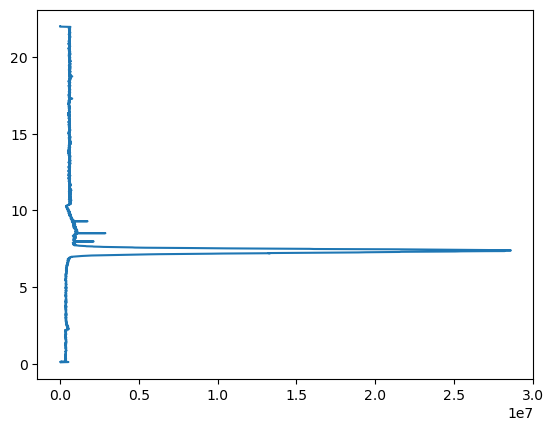

In [8]:
def get_chrom_duckdb(database):
    conn = duckdb.connect(database)
    query_data = conn.execute("SELECT * FROM MS1 WHERE ABS(mz-118.0865) <= 0.001").fetch_df()
    conn.close()
    return query_data
print(chrom_data)
chrom_data = get_chrom_duckdb("msdata.duckdb")

plt.plot(chrom_data["rt"], chrom_data["int"])
plt.show()

## Compare the time required to run each of the extraction functions

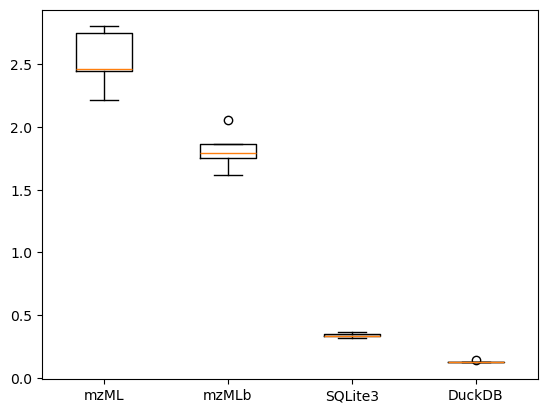

In [15]:
import timeit

mzml_times = timeit.repeat('get_chrom_mzml("210916_Poo_TruePooAmm-noIS-pos-Full_1.mzML")', globals=globals(), number=1, repeat = 5)
mzmlb_times = timeit.repeat('get_chrom_mzmlb("210916_Poo_TruePooAmm-noIS-pos-Full_1.mzMLb")', globals=globals(), number=1, repeat = 5)
sql_times = timeit.repeat('get_chrom_sqlite3("msdata.sqlite")', globals=globals(), number=1, repeat = 10)
duckdb_times = timeit.repeat('get_chrom_duckdb("msdata.duckdb")', globals=globals(), number=1, repeat = 10)

plt.boxplot([mzml_times, mzmlb_times, sql_times, duckdb_times], tick_labels=['mzML', 'mzMLb', 'SQLite3', 'DuckDB'])
plt.show()

## Sizes on disk

In [13]:
import os
print(os.path.getsize('210916_Poo_TruePooAmm-noIS-pos-Full_1.mzML'))
print(os.path.getsize('210916_Poo_TruePooAmm-noIS-pos-Full_1.mzMLb'))
print(os.path.getsize('msdata.sqlite'))
print(os.path.getsize('msdata.duckdb'))

50652936
59792356
93589504
40906752


## Playing with indices to see if we can further improve the SQLite time

In [ ]:
import shutil

shutil.copy("msdata.db", "msdata_ord.db")

conn = sqlite3.connect("msdata_ord.db")
conn.cursor().execute("CREATE TABLE MS1_ord AS SELECT * FROM MS1 ORDER BY mz")
conn.cursor().execute("DROP TABLE MS1")
conn.cursor().execute("ALTER TABLE MS1_ord RENAME TO MS1")
conn.close()

In [ ]:
shutil.copy("msdata.db", "msdata_idx.db")

conn = sqlite3.connect("msdata_idx.db")
conn.cursor().execute("CREATE INDEX idx_mz ON MS1(mz)")
conn.close()

In [ ]:
shutil.copy("msdata_ord.db", "msdata_ord_idx.db")

conn = sqlite3.connect("msdata_ord_idx.db")
conn.cursor().execute("CREATE TABLE MS1_ord AS SELECT * FROM MS1 ORDER BY mz")
conn.cursor().execute("DROP TABLE MS1")
conn.cursor().execute("ALTER TABLE MS1_ord RENAME TO MS1")
conn.cursor().execute("CREATE INDEX idx_mz ON MS1(mz)")
conn.close()

In [ ]:
print(os.path.getsize('msdata.db'))
print(os.path.getsize('msdata_ord.db'))
print(os.path.getsize('msdata_idx.db'))
print(os.path.getsize('msdata_ord_idx.db'))

In [ ]:
init_times = timeit.repeat('get_chrom_sqlite3("msdata.db")', globals=globals(), number=1, repeat = 10)
ord_times = timeit.repeat('get_chrom_sqlite3("msdata_ord.db")', globals=globals(), number=1, repeat = 10)
idx_times = timeit.repeat('get_chrom_sqlite3("msdata_idx.db")', globals=globals(), number=1, repeat = 10)
ord_idx_times = timeit.repeat('get_chrom_sqlite3("msdata_ord_idx.db")', globals=globals(), number=1, repeat = 10)

plt.boxplot([init_times, ord_times, idx_times, ord_idx_times], tick_labels=['Init', 'Ordered', 'Indexed', 'Both'])
plt.show()

In [ ]:
conn.close()
os.remove("msdata.db")
os.remove("msdata_idx.db")
os.remove("msdata_ord.db")
os.remove("msdata_ord_idx.db")